# A Network Tour of Data Science, EPFL 2016
# Project: Facial Emotion Recognition
students: Patryk Oleniuk, Carmen Galotta



In [3]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy.misc

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Data Visualization
# Load the shortened raw CSV data, it contains only 300 pictures with labels
emotions_dataset_dir = 'fer2013_shortened.csv'

# TODO remove these fiunctions to utils
def get_min_max( img ):
    return np.min(np.min(img)),np.max(np.max(img))

def remap(img, min, max):
    return (img-min) * 1.0/(max-min)

def contrast_stretch(img ):
    min, max = get_min_max( img );
    return remap(img, min, max)


# Load the data from *.csv file 
The format od the csv line is<br>
class{0,1,2,3,4,5,6},pix0 pix2304,DataUsage(not used)<br>
e.g.<br>
2,234 1 34 23 ..... 234 256 0,Training<br>
The picture is always 48x48 pixels, 0-255 greyscale.
# Remove crappy data
In the database there are some images thar are not good (e.g. some images are pixelated, unrelevant, from animations).
We try to filter them by looking at the maximum of the histogram. If the image is very homogenous, the maximum value of the histogram will be very high (above certain threshold)-> then we filter this image out. Of course we also remove some relevant information, but it's better for our CNN not to consider these images.

1108 are left after 'strange images' removal.
Deleted 92 strange images. Images are shown below


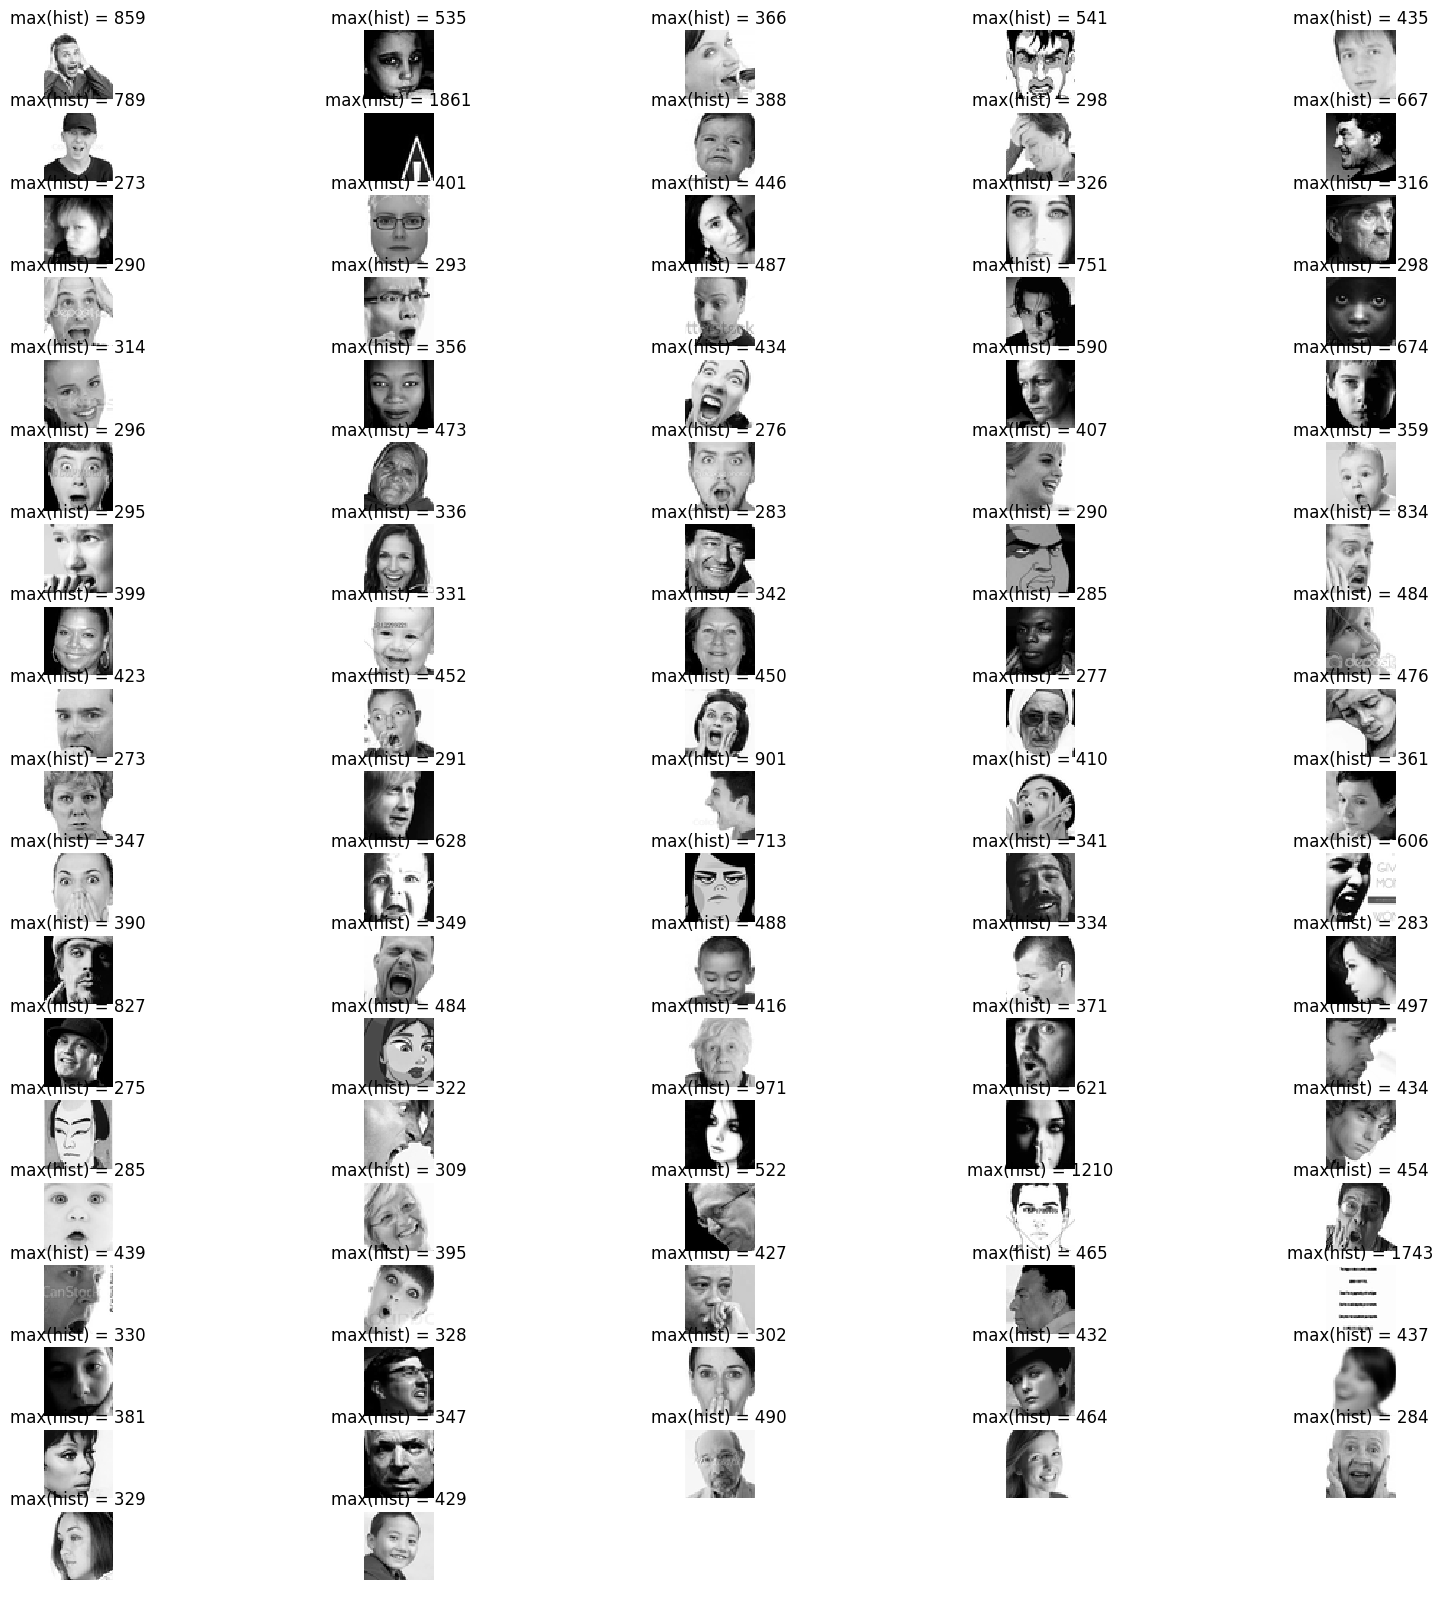

In [4]:
#Load the file in csv
ifile  = open(emotions_dataset_dir, "rt")
reader = csv.reader(ifile)

#preparing labels(Y) and images(X) data vectors
rownum = 0
num_data = 1200; #TODO how to obtain number of rows

#preparing arrays
emotions = np.zeros(num_data)
images = np.zeros((num_data,48,48))
strange_im = np.zeros((num_data,48,48))

# for image pre-filtering
num_strange = 0; #number of removed images
hist_threshold = 270 # images above this threshold will be removed
hist_div = 100 #parameter of the histogram

#parsing each row
for row in reader:
    #(column0) extract the emotion label
    emotions[rownum] = row[0]
    #(column1) extract the image data, parse it and convert into 48x48 array of integers
    images[rownum] = np.asarray([int(s) for s in row[1].split(' ')]).reshape(48,48)
    
    #stretching contrast of the image
    images[rownum] = contrast_stretch(images[rownum])
    
    #calculating the histogram and erasing "strange" images
    y_h, x_h = np.histogram( images[ rownum ] ,hist_div);
    if y_h.max() > hist_threshold  : 
        # if img is 'strange'
        strange_im[num_strange,:,:] = images[rownum,:,:]
        num_data = num_data - 1;
        images = np.delete(images, rownum, axis = 0);
        emotions = np.delete(emotions, rownum)
        num_strange = num_strange + 1;   
    else:
        rownum += 1
ifile.close()

print(str( len(images) ) + ' are left after \'strange images\' removal.')
print('Deleted ' + str( num_strange ) + ' strange images. Images are shown below')

# showing strange images
for i in range(0,int(num_strange)):
    plt.subplot( int(np.ceil(num_strange/5)),5,  i+1)
    plt.imshow(strange_im[i])
    y_h, x_h = np.histogram( strange_im[i,:,:] ,hist_div);
    strange_im.sort(axis=0, )
    plt.axis('off')
    plt.title('max(hist) = ' + str(y_h.max()))

# Explore the data
Plot some random pictures from each class.

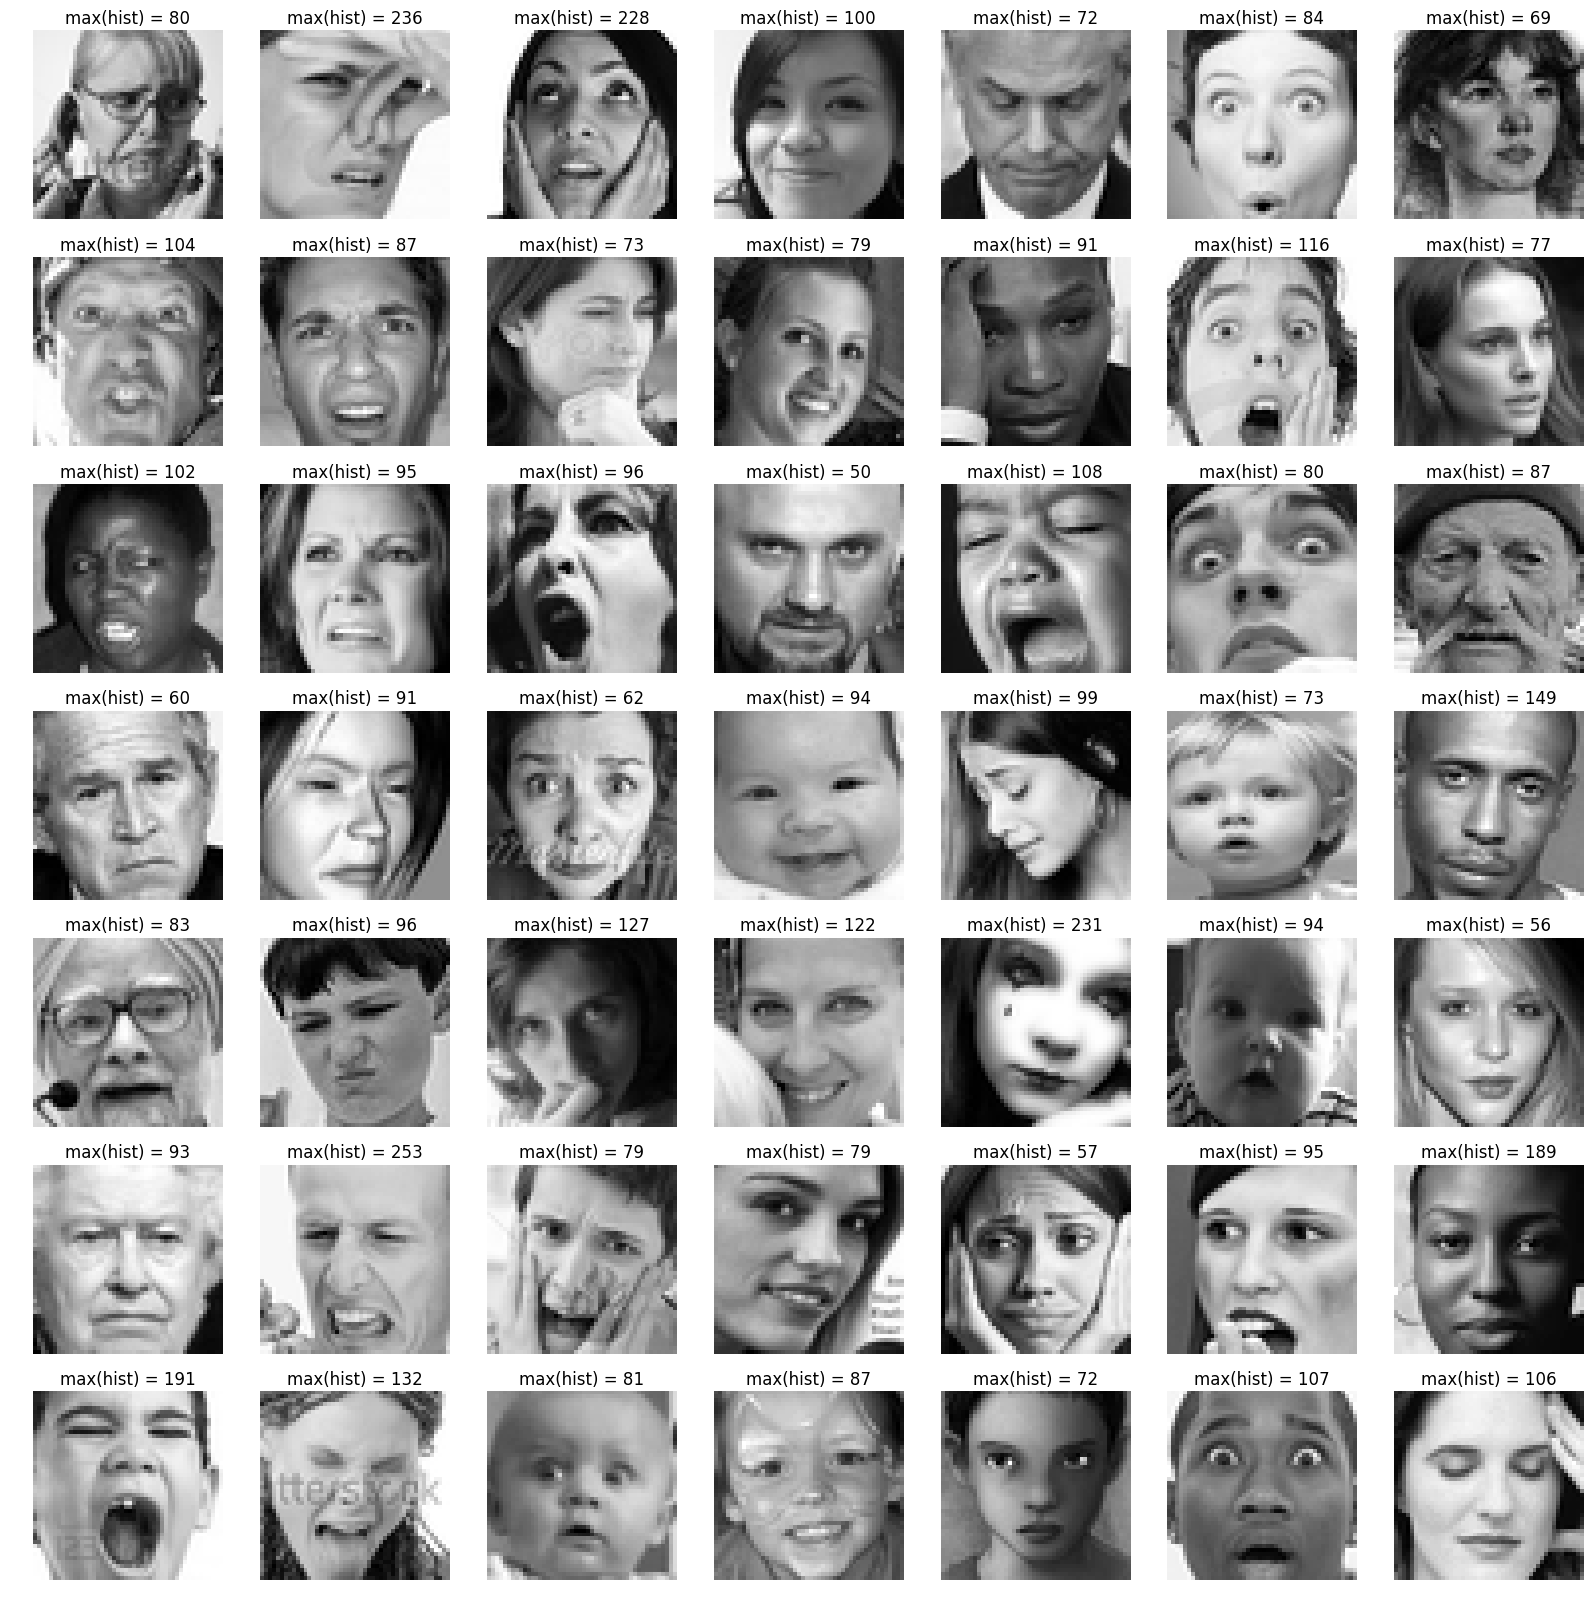

In [5]:
classes = [0,1,2,3,4,5,6 ]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(emotions == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        
        plt.imshow(images[idx])
        y_h, x_h = np.histogram( images[idx], hist_div );
        plt.axis('off')
        plt.title('max(hist) = ' + str(y_h.max()))
plt.show()

# Prepare the computational graph
Tensorflow